## Imports

In [1]:
# necessary imports
import random
import pandas as pd
import numpy as np
import os
import cv2
import tensorflow as tf
from tensorflow.keras import datasets, layers, models #gpu
# import # macro f1 score - https://bestkcs1234.tistory.com/61

# import albumentations as A
# https://albumentations.ai/docs/examples/tensorflow-example/
from albumentations import (
    Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip,
    Rotate
)

from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore')

## Hyperparameter Setting

In [2]:
CFG = {
    'FPS' : 30,
    'IMG_SIZE': 128,
    'EPOCHS': 10,
    'LEARNING_RATE': 3e-4,
    'BATCH_SIZE': 4,
    'SEED': 41
}

## Fixed RandomSeed

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(CFG['SEED']) # SEED 고정
    

## Data Load

In [4]:
train = pd.read_csv('./data/train.csv')

In [5]:
train.head()

,id,path,label
0,TRAIN_000,./train/TRAIN_000.mp4,3
1,TRAIN_001,./train/TRAIN_001.mp4,0
2,TRAIN_002,./train/TRAIN_002.mp4,1
3,TRAIN_003,./train/TRAIN_003.mp4,4
4,TRAIN_004,./train/TRAIN_004.mp4,4


In [6]:
train['label'].value_counts()

3    133
1    129
2    121
4    114
0    113
Name: label, dtype: int64

### train 데이터 label 분포

In [7]:
train['label'].value_counts().values

array([133, 129, 121, 114, 113])

([<matplotlib.patches.Wedge at 0x2c68522e0>,
 [Text(0.8518816777434608, 0.6959149424498562, '3'),
  Text(-0.49180322740623394, 0.9839357628995972, '1'),
  Text(-1.0821777337152425, -0.1972089061146626, '2'),
  Text(-0.1972087541334739, -1.082177761411277, '4'),
  Text(0.9189213344776592, -0.6046350808891245, '0')],
 [Text(0.46466273331461494, 0.3795899686090124, '21.8%'),
  Text(-0.26825630585794574, 0.5366922343088711, '21.1%'),
  Text(-0.5902787638446777, -0.10756849424436142, '19.8%'),
  Text(-0.10756841134553122, -0.5902787789516056, '18.7%'),
  Text(0.5012298188059958, -0.3298009532122497, '18.5%')])

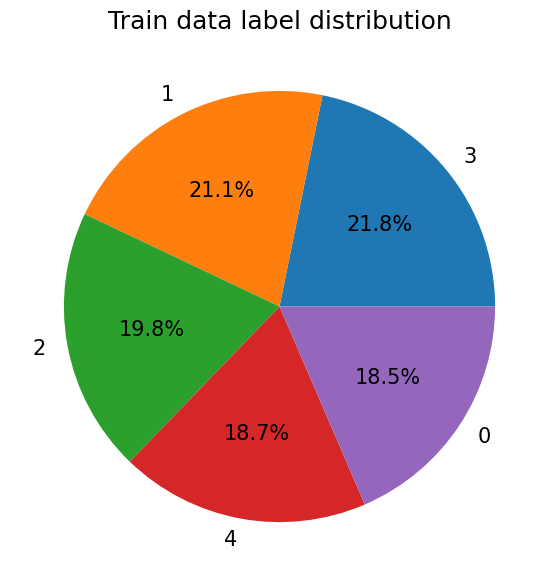

In [8]:
mpl.rc('font', size=15)
plt.figure(figsize=(7, 7))

label = ['3', '1', '2', '4', '0'] # 타깃값 레이블
plt.title('Train data label distribution')
plt.pie(train['label'].value_counts().values, labels=label, autopct='%.1f%%')


In [9]:
test = pd.read_csv('./data/test.csv')

In [10]:
test.head()

,id,path
0,TEST_000,./test/TEST_000.mp4
1,TEST_001,./test/TEST_001.mp4
2,TEST_002,./test/TEST_002.mp4
3,TEST_003,./test/TEST_003.mp4
4,TEST_004,./test/TEST_004.mp4


## Train/ Validation Split

In [11]:
_, val, _, _ = train_test_split(train, train['label'], test_size=0.2, stratify=train['label'], random_state=CFG['SEED'])

In [12]:
val.shape

(122, 3)

In [13]:
val.head()

,id,path,label
445,TRAIN_445,./train/TRAIN_445.mp4,0
209,TRAIN_209,./train/TRAIN_209.mp4,3
456,TRAIN_456,./train/TRAIN_456.mp4,4
382,TRAIN_382,./train/TRAIN_382.mp4,3
212,TRAIN_212,./train/TRAIN_212.mp4,0


In [14]:
val.reset_index(inplace=True)

In [15]:
val.head()

,index,id,path,label
0,445,TRAIN_445,./train/TRAIN_445.mp4,0
1,209,TRAIN_209,./train/TRAIN_209.mp4,3
2,456,TRAIN_456,./train/TRAIN_456.mp4,4
3,382,TRAIN_382,./train/TRAIN_382.mp4,3
4,212,TRAIN_212,./train/TRAIN_212.mp4,0


In [16]:
val.drop(columns='index', axis=1, inplace=True)
val.head()

,id,path,label
0,TRAIN_445,./train/TRAIN_445.mp4,0
1,TRAIN_209,./train/TRAIN_209.mp4,3
2,TRAIN_456,./train/TRAIN_456.mp4,4
3,TRAIN_382,./train/TRAIN_382.mp4,3
4,TRAIN_212,./train/TRAIN_212.mp4,0


## CustomDataset

In [17]:
file_path = './data/train/' + train.loc[0]['id'] + '.mp4'
file_path

'./data/train/TRAIN_000.mp4'

In [18]:
# 1초에 30프레임

frames = []
cap = cv2.VideoCapture(file_path) # 영상 불러오기 30프레임 리턴됨.
for _ in range(CFG['FPS']): # 프레임 단위로 짤라서 반복문안에서 처리
    _, img = cap.read() # 30프레임중에 한개씩
    img = cv2.resize(img, (CFG['IMG_SIZE'], CFG['IMG_SIZE'])) # img 리사이징
    img = img / 255. # 픽셀값 정규화 RGB 별로 각각 0~255 사이의 값을 가지는 픽셀값의 array들을 0~1 사이값으로 정규화
    frames.append(img)

[ WARN:0@21.496] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664548333142/work/modules/videoio/src/cap_gstreamer.cpp (2386) handleMessage OpenCV | GStreamer warning: your GStreamer installation is missing a required plugin
[ WARN:0@21.496] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664548333142/work/modules/videoio/src/cap_gstreamer.cpp (2402) handleMessage OpenCV | GStreamer warning: Embedded video playback halted; module uridecodebin0 reported: Your GStreamer installation is missing a plug-in.
[ WARN:0@21.497] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664548333142/work/modules/videoio/src/cap_gstreamer.cpp (1356) open OpenCV | GStreamer warning: unable to start pipeline
[ WARN:0@21.497] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664

In [19]:
frames[1].shape

(128, 128, 3)

In [20]:
np.array(frames).shape

(30, 128, 128, 3)

In [21]:
train.head()

,id,path,label
0,TRAIN_000,./train/TRAIN_000.mp4,3
1,TRAIN_001,./train/TRAIN_001.mp4,0
2,TRAIN_002,./train/TRAIN_002.mp4,1
3,TRAIN_003,./train/TRAIN_003.mp4,4
4,TRAIN_004,./train/TRAIN_004.mp4,4


In [22]:
len(train)

610

In [23]:
frames_train = []
train_label = []
frames_val = []
val_label = []

for i in tqdm(range(len(train))):
    file_name = train.loc[i,'id']
    label = train.loc[i, 'label']
    file_path = f'./data/train/{file_name}.mp4'
    cap = cv2.VideoCapture(file_path)
    for _ in range(CFG['FPS']):
        _, img = cap.read()
        img = cv2.resize(img, (CFG['IMG_SIZE'], CFG['IMG_SIZE']))
        img = img / 255.
        frames_train.append(img)
        train_label.append(label)


for i in tqdm(range(len(val))):
    file_name = val.loc[i, 'id']
    label = val.loc[i, 'label']
    file_path = f'./data/train/{file_name}.mp4'
    cap = cv2.VideoCapture(file_path)
    for _ in range(CFG['FPS']):
        _, img = cap.read()
        img = cv2.resize(img, (CFG['IMG_SIZE'], CFG['IMG_SIZE']))
        img = img / 255.
        frames_val.append(img)
        val_label.append(label)

  0%|          | 0/610 [00:00<?, ?it/s]

[ WARN:0@25.510] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664548333142/work/modules/videoio/src/cap_gstreamer.cpp (2386) handleMessage OpenCV | GStreamer warning: your GStreamer installation is missing a required plugin
[ WARN:0@25.510] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664548333142/work/modules/videoio/src/cap_gstreamer.cpp (2402) handleMessage OpenCV | GStreamer warning: Embedded video playback halted; module uridecodebin1 reported: Your GStreamer installation is missing a plug-in.
[ WARN:0@25.511] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664548333142/work/modules/videoio/src/cap_gstreamer.cpp (1356) open OpenCV | GStreamer warning: unable to start pipeline
[ WARN:0@25.511] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664

  0%|          | 0/122 [00:00<?, ?it/s]

[ WARN:0@35.501] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664548333142/work/modules/videoio/src/cap_gstreamer.cpp (2386) handleMessage OpenCV | GStreamer warning: your GStreamer installation is missing a required plugin
[ WARN:0@35.501] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664548333142/work/modules/videoio/src/cap_gstreamer.cpp (2402) handleMessage OpenCV | GStreamer warning: Embedded video playback halted; module uridecodebin611 reported: Your GStreamer installation is missing a plug-in.
[ WARN:0@35.501] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664548333142/work/modules/videoio/src/cap_gstreamer.cpp (1356) open OpenCV | GStreamer warning: unable to start pipeline
[ WARN:0@35.501] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_16

In [24]:
np.array(frames_train).shape, np.array(frames_val).shape

((18300, 128, 128, 3), (3660, 128, 128, 3))

In [25]:
# train, val set
frames_train = np.array(frames_train)
frames_val = np.array(frames_val)
train_label = np.array(train_label)
val_label = np.array(val_label)

In [26]:
val['label'].values

array([0, 3, 4, 3, 0, 3, 3, 4, 1, 3, 3, 0, 1, 2, 2, 2, 3, 0, 3, 4, 3, 1,
       4, 0, 4, 1, 1, 4, 4, 1, 3, 3, 0, 4, 1, 4, 3, 2, 1, 4, 0, 0, 3, 3,
       2, 1, 3, 3, 2, 1, 2, 1, 4, 2, 4, 0, 1, 2, 0, 0, 1, 0, 0, 2, 4, 2,
       0, 0, 0, 3, 3, 1, 0, 4, 1, 1, 2, 2, 0, 3, 3, 0, 4, 3, 4, 0, 3, 1,
       1, 1, 4, 1, 1, 2, 1, 3, 4, 2, 2, 4, 2, 4, 2, 2, 3, 0, 4, 4, 2, 3,
       2, 1, 2, 0, 0, 3, 2, 1, 1, 2, 1, 4])

In [28]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(5))

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 flatten_1 (Flatten)         (None, 50176)            

In [31]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history = model.fit(frames_train, train_label, epochs=3, batch_size=4, validation_data=(frames_val, val_label))


Epoch 1/3


2023-01-22 13:56:34.714136: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4573/4575 [============================>.] - ETA: 0s - loss: 0.2541 - accuracy: 0.9013

2023-01-22 13:57:17.484114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4575/4575 [==============================] - 48s 10ms/step - loss: 0.2540 - accuracy: 0.9014 - val_loss: 0.0362 - val_accuracy: 0.9874
Epoch 2/3
4575/4575 [==============================] - 46s 10ms/step - loss: 0.0341 - accuracy: 0.9912 - val_loss: 2.9410e-04 - val_accuracy: 1.0000
Epoch 3/3
4575/4575 [==============================] - 46s 10ms/step - loss: 0.0250 - accuracy: 0.9940 - val_loss: 0.0145 - val_accuracy: 0.9943


In [32]:
preds = []

In [33]:
test.head()

,id,path
0,TEST_000,./test/TEST_000.mp4
1,TEST_001,./test/TEST_001.mp4
2,TEST_002,./test/TEST_002.mp4
3,TEST_003,./test/TEST_003.mp4
4,TEST_004,./test/TEST_004.mp4


In [34]:
frames_test = []
file_path = f'./data/test/TEST_000.mp4'
cap = cv2.VideoCapture(file_path)
for _ in range(CFG['FPS']):
    _, img = cap.read()
    img = cv2.resize(img, (CFG['IMG_SIZE'], CFG['IMG_SIZE']))
    img = img / 255.
    frames_test.append(img)

[ WARN:0@831.088] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664548333142/work/modules/videoio/src/cap_gstreamer.cpp (2386) handleMessage OpenCV | GStreamer warning: your GStreamer installation is missing a required plugin
[ WARN:0@831.088] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664548333142/work/modules/videoio/src/cap_gstreamer.cpp (2402) handleMessage OpenCV | GStreamer warning: Embedded video playback halted; module uridecodebin733 reported: Your GStreamer installation is missing a plug-in.
[ WARN:0@831.088] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664548333142/work/modules/videoio/src/cap_gstreamer.cpp (1356) open OpenCV | GStreamer warning: unable to start pipeline
[ WARN:0@831.088] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suit

In [48]:
frames_test = np.array(frames_test)

In [52]:
model.predict(frames_test)

1/1 [==============================] - 0s 179ms/step


2023-01-22 14:09:28.680429: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([[ 16.044266  ,   5.818931  ,  -4.9376345 , -14.654606  ,
         -4.235715  ],
       [ 16.584679  ,   5.854837  ,  -5.063183  , -14.443554  ,
         -4.2226844 ],
       [ 16.507305  ,   5.5274553 ,  -5.9935656 , -12.6933    ,
         -4.0308833 ],
       [ 16.804909  ,   4.636453  ,  -7.2483788 , -12.8815565 ,
         -2.8034194 ],
       [ 12.735119  ,   9.958811  ,  -7.1248727 , -13.614504  ,
         -2.673775  ],
       [ 12.120773  ,   9.452218  ,  -6.644155  , -12.901793  ,
         -3.552821  ],
       [ 11.472087  ,   9.0489025 ,  -6.3646393 , -12.8633795 ,
         -3.4954178 ],
       [ 11.57839   ,   8.857348  ,  -6.4051895 , -12.311493  ,
         -3.7135813 ],
       [ 11.521288  ,   8.684014  ,  -6.2882357 , -12.56497   ,
         -3.6132605 ],
       [ 11.236467  ,   9.209619  ,  -6.244825  , -12.7587185 ,
         -3.3948987 ],
       [ 11.339072  ,   9.336986  ,  -6.167964  , -12.683042  ,
         -3.237662  ],
       [ 10.851     ,   9.709912  ,  -5.827

In [ ]:
# for file_name in (test['id'].values):
#     file_path = f'./data/test/{file_name}.mp4'
#     cap = cv2.VideoCapture(file_path)
#     tmp = []
#     for _ in range(CFG['FPS']):
#         _, img = cap.read()
#         img = cv2.resize(img, (CFG['IMG_SIZE'], CFG['IMG_SIZE']))
#         img = img / 255.
#         frames_train.append(img)
#         train_label.append(label)
    